# cGAN reconstruct

In [ ]:
import os
import io
import cv2
import copy
import math
import random
import numpy as np
import pickle as pkl
import datetime
from collections import deque
from tqdm import tqdm, trange
from typing import Deque, Dict, List, Tuple

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split


## hyper parameters

In [ ]:
parameters = dict(
    kernel=3,
    stride=2,
    padding=2,
    deconv_dim=32,
    deconv_channel=128,
    adjust_linear=235,
    epoch=100,
    beta1=0.5,
    learning_rate=0.0002,
    nz=100,
    lambda_l1=1,
    batch_size=128,
    vis_num=4,
    visualize_epoch=10,
)

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
config = Struct(**parameters)

## download & prepare dataset

In [ ]:
!gdown --id 1w-o0896Biga-DrSG0gZKq9z4y5bFWuW8
!unzip -o -q pkl-transitions-20210704T103021Z-001.zip

Downloading...
From: https://drive.google.com/uc?id=1w-o0896Biga-DrSG0gZKq9z4y5bFWuW8
To: /content/pkl-transitions-20210704T103021Z-001.zip
108MB [00:00, 151MB/s] 


In [ ]:
paths = []
main_path = '/content/pkl-transitions'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    for d2 in dirs1:
        paths.append(main_path+'/'+d+'/'+d2)
print('%d files' % len(paths))

228 files


In [ ]:
class MMDataset(Dataset):
    def __init__(self, paths):
        self.transitions = []

        for p in tqdm(paths):
            with open(p, "rb") as f:
                demo = pkl.load(f, encoding="bytes")
                self.transitions.extend(demo)

    def __getitem__(self, index):
        mm_scan = self.transitions[index][b'mm_scan']
        laser_scan = self.transitions[index][b'laser_scan']
        mm_scan = torch.Tensor(mm_scan).reshape(1, -1)
        laser_scan = torch.Tensor(laser_scan).reshape(1, -1)

        return mm_scan, laser_scan

    def __len__(self):
        return len(self.transitions)

In [ ]:
mm_dataset = MMDataset(paths)

loader = DataLoader(dataset=mm_dataset,
                    batch_size=config.batch_size,
                    shuffle=True,
                    num_workers=2)


100%|██████████| 228/228 [00:03<00:00, 60.75it/s]


## models

### generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )

        dim = 64*59
        self.linear = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

        self.de_fc1 = nn.Sequential(
            nn.Linear(128, config.deconv_channel*config.deconv_dim),
            nn.ReLU()
        )

        self.de_conv = nn.Sequential(
            nn.ConvTranspose1d(config.deconv_channel, config.deconv_channel //
                               2, kernel, stride=stride, padding=config.padding),
            nn.ConvTranspose1d(config.deconv_channel//2, config.deconv_channel //
                               4, kernel, stride=stride, padding=config.padding),
            nn.ConvTranspose1d(config.deconv_channel//4, 1,
                               kernel, stride=stride, padding=config.padding),
        )
        self.adjust_linear = nn.Sequential(
            nn.Linear(config.adjust_linear, 241),
            nn.ReLU()
        )

    def encoder(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def decoder(self, x):
        x = self.de_fc1(x)
        x = x.view(-1, config.deconv_channel, config.deconv_dim)
        x = self.de_conv(x)
        x = self.adjust_linear(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )

        dim = 64*59
        self.linear = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

### patched discriminator

In [ ]:
class DiscriminatorPatch(nn.Module):
    def __init__(self):
        super(DiscriminatorPatch, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=kernel, stride=stride),
            nn.Sigmoid(),
        )

    def forward(self, x):

        x = self.conv(x)

        return x

## train

### config

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ', device)

netG = Generator().to(device)
netD = Discriminator().to(device)
# netD = DiscriminatorPatch().to(device)

# optimizers
optimizer_g = optim.Adam(netG.parameters(),
                         lr=config.learning_rate, betas=(config.beta1, 0.999))
optimizer_d = optim.Adam(netD.parameters(),
                         lr=config.learning_rate, betas=(config.beta1, 0.999))

# criterion
# gan_loss = nn.BCEWithLogitsLoss()
gan_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

device,  cuda:0


### start

In [ ]:
def set_requires_grad(net, requires_grad=False):
    for param in net.parameters():
        param.requires_grad = requires_grad

In [ ]:
log_metrics = {
    'loss_D_real': [],
    'loss_D_fake': [],
    'loss_D': [],
    'loss_G_gan': [],
    'loss_G_l1': [],
    'loss_G': [],
}

step = 0
t = trange(config.epoch)

for epoch in t:
    for mm_scan, laser_scan in loader:
        x = mm_scan.to(device)
        y = laser_scan.to(device)

        # patch size 14
        # fake_label = Variable(torch.Tensor(
        #     np.zeros((x.size(0), 1, 14))), requires_grad=False).to(device)
        # real_label = Variable(torch.Tensor(
        #     np.ones((x.size(0), 1, 14))), requires_grad=False).to(device)

        # patch size 1
        fake_label = Variable(torch.Tensor(
            np.zeros((x.size(0), 1))), requires_grad=False).to(device)
        real_label = Variable(torch.Tensor(
            np.ones((x.size(0), 1))), requires_grad=False).to(device)

        fake_y = netG(x)

        ########################### train D ############################

        set_requires_grad(netD, True)
        optimizer_d.zero_grad()

        # fake
        fake_xy = torch.cat((x, fake_y), dim=1)
        pred_fake = netD(fake_xy.detach())
        loss_D_fake = gan_loss(pred_fake, fake_label)

        # real
        real_xy = torch.cat((x, y), dim=1)
        pred_real = netD(real_xy)
        loss_D_real = gan_loss(pred_real, real_label)

        # train
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_d.step()

        ########################### train G ############################

        set_requires_grad(netD, False)
        optimizer_g.zero_grad()

        pred_fake = netD(fake_xy)
        loss_G_gan = gan_loss(pred_fake, real_label)
        loss_G_l1 = l1_loss(fake_y, y) * config.lambda_l1
        loss_G = loss_G_gan + loss_G_l1
        loss_G.backward()
        optimizer_g.step()

        ########################### log ##################################

        log_metrics['loss_D_real'].append(loss_D_real.item())
        log_metrics['loss_D_fake'].append(loss_D_fake.item())
        log_metrics['loss_D'].append(loss_D.item())
        log_metrics['loss_G_gan'].append(loss_G_gan.item())
        log_metrics['loss_G_l1'].append(loss_G_l1.item())
        log_metrics['loss_G'].append(loss_G.item())

        step += 1
        t.set_description('step: %d' % step)

step: 86100: 100%|██████████| 100/100 [34:39<00:00, 20.80s/it]


### logs

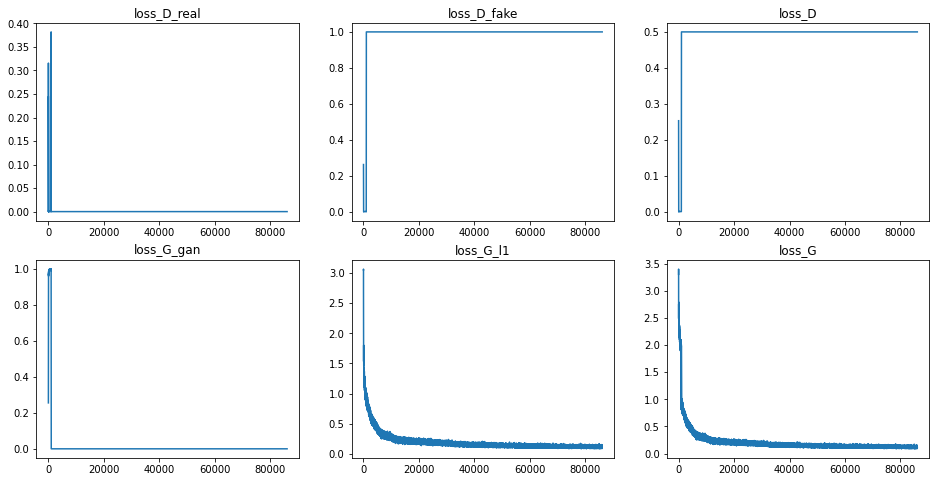

In [ ]:
fig = plt.figure(figsize=(16,8))
indx = 1
for k, v in log_metrics.items():
  ax = plt.subplot(2,3,indx)
  plt.title(k)
  plt.plot(np.arange(len(v)), v)
  indx+=1

## load pretrained model (optional)

In [ ]:
!gdown --id 1xgoDOfO4dFkqS11ChJd4THjP5oKTY-Mx

Downloading...
From: https://drive.google.com/uc?id=1xgoDOfO4dFkqS11ChJd4THjP5oKTY-Mx
To: /content/0827_1851.pth
10.5MB [00:00, 156MB/s]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ', device)
netG = Generator().to(device)

netG.load_state_dict(torch.load("/content/0827_1851.pth"))
netG.eval()

device,  cuda:0


Generator(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=3776, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (de_fc1): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU()
  )
  (de_conv): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(2,))
    (2): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(2,), padding=(2,))
  )
  (adjust_linear): Sequential(
    (0): Linear(in_features=235, out_features=241, bias=True)
    (1): ReLU()
  )
)

## evaluation

In [ ]:
name_corridor = [
'0717_1411','0720_1129','0722_1428','0722_1437','0722_1448','0722_1500',
'0722_1506','0722_1510','0722_1514','0724_1101','0724_1132','0724_1204',
'0727_1005','0727_1027','0727_1102','0727_1435','0727_1452','0727_1510',
'0727_1520','0805_1108','0805_1127','0805_1147']

name_parking = ['0717_1504','0720_1105','0805_1349','0805_1425']

paths_corridor, paths_parking = [], []
main_path = '/content/pkl-transitions'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    for d2 in dirs1:
        if any(s in d2 for s in name_corridor):
            paths_corridor.append(main_path+'/'+d+'/'+d2)
        elif any(s in d2 for s in name_parking):
            paths_parking.append(main_path+'/'+d+'/'+d2)
print('corridor files %d'%len(paths_corridor))
print('parking files %d'%len(paths_parking))

corridor files 153
parking files 31


In [ ]:
batch_size = 128
netG.eval()

corridor_dataset = MMDataset(paths_corridor)
loader_corridor = DataLoader(dataset=corridor_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

parking_dataset = MMDataset(paths_parking)
loader_parking = DataLoader(dataset=parking_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

100%|██████████| 31/31 [00:00<00:00, 70.14it/s]


In [ ]:
l1 = nn.L1Loss()

L1 = []
for mm_scan, laser_scan in loader_corridor:
    mm_scan = mm_scan.to(device)
    
    x_hat = netG(mm_scan)
    x_hat = x_hat.detach().cpu()
    
    L1.append(l1(laser_scan,x_hat))
    
print("\n corridor L1: %.4f"%np.mean(L1))


 corridor L1: 0.0922


In [ ]:
L1 = []
for mm_scan, laser_scan in loader_parking:
    mm_scan = mm_scan.to(device)
    
    x_hat = netG(mm_scan)
    x_hat = x_hat.detach().cpu()
    
    L1.append(l1(laser_scan,x_hat))

    
print("\n parking L1: %.4f"%np.mean(L1))


 parking L1: 0.1078


## visualize

In [ ]:
def laser_visual(lasers=[], names=[], range_limit=6):
  fig = plt.figure(figsize=(8, 8))
  colors=['#3483EB','#FFA500','#15B01D']
  for i, l in enumerate(lasers):
    angle = 120
    xp = []
    yp = []
    for r in l:
        if r <= range_limit:
            yp.append(r * math.cos(math.radians(angle)))
            xp.append(r * math.sin(math.radians(angle)))
        angle -= 1
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.plot(xp, yp, '.', color=colors[i], label=names[i])
  plt.legend(loc='lower right', fontsize=15)

### reconstruct sample
repeate this block to visualize different samples

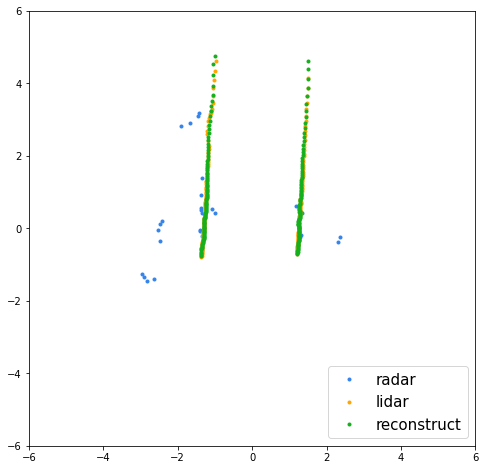

In [ ]:
sample_loader=loader
# sample_loader=loader_corridor
# sample_loader=loader_parking

mm_scan, laser_scan = next(iter(sample_loader))
x = mm_scan.to(device)
reconstruct = netG(x)[0][0].detach().cpu().numpy()
mm_scan=mm_scan[0][0].numpy()
laser_scan=laser_scan[0][0].numpy()

laser_visual([mm_scan, laser_scan, reconstruct], names=['radar', 'lidar', 'reconstruct'], range_limit=4.9)